In [1]:
import csv, os, glob, torch, time
from dataloader.dataset import UnlabeledDataset2, UnlabeledTransform2
import torch.utils.data as data
from utils.module import EarlyStopping
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

In [53]:
# 6000x3000画像に対してひび割れ検出を行う
import torch
import torch.utils.data as data
from dataloader.dataset import PanoImageDataset
from models.bayesian_deeplab import DeepLabv3plusModel

image_dir = 'data/original_split_resized/'
file = 'c97'
mask_dir = 'data/teacher_split_resized/'
test_dataset = PanoImageDataset(image_dir, file)

test_dataloader = data.DataLoader(
    test_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)

model_wrapper = DeepLabv3plusModel()
model = model_wrapper.get_model()

model = torch.nn.DataParallel(model, device_ids=[0, 1, 2, 3])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

model_path = 'weights/231124/iter1_weights/best.pth'
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

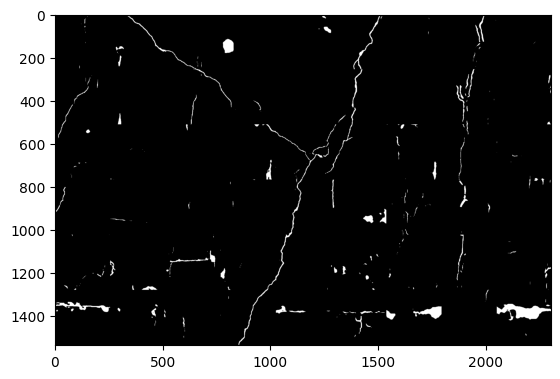

In [54]:
import numpy as np
count = 0
pred_mask = np.zeros((1536,2304))
for inputs in test_dataloader:
    inputs = inputs.to(device)
    # outputs = (batch,1,256,256)
    outputs = model(inputs)
    outputs = torch.sigmoid(outputs)
    
    for i in range(outputs.size(0)):
        # predは(256,256)
        pred = outputs[i].cpu().detach().numpy()[0]
        pred = np.where(pred >= 0.5, 1, 0)
        
        row, col = count//9, count%9
        pred_mask[row*256:(row+1)*256, col*256:(col+1)*256] = pred
        count += 1

plt.imshow(pred_mask, cmap='gray')

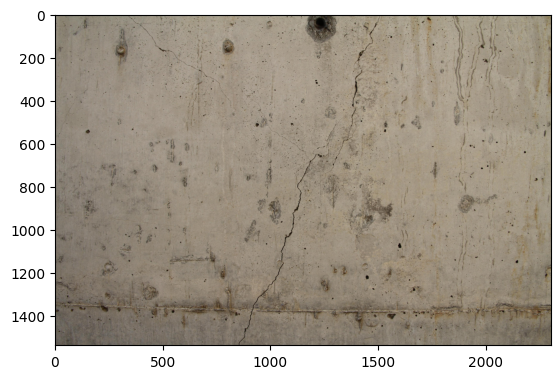

In [55]:
from PIL import Image
image_files = glob.glob(image_dir + file + '*')
image_files = sorted(image_files, key=lambda x: (int(x.split('_')[3]), int(x.split('_')[4].rstrip('.jpg'))))

image = np.ones((1536,2304,3),dtype=np.uint8)
for count in range(len(image_files)):
    img = Image.open(image_files[count])
    img = img.resize((256,256))
    img = np.array(img)
    row, col = count//9, count%9
    image[row*256:(row+1)*256, col*256:(col+1)*256, :] = img
    
plt.imshow(image)

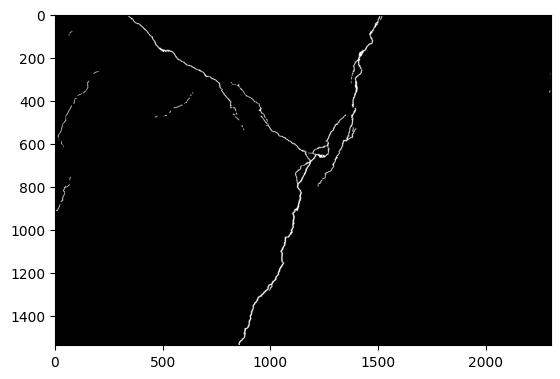

In [56]:
mask_files = glob.glob(mask_dir + file + '*')
mask_files = sorted(mask_files, key=lambda x: (int(x.split('_')[3]), int(x.split('_')[4].rstrip('.bmp'))))

mask = np.ones((1536,2304),dtype=np.uint8)
for count in range(len(mask_files)):
    msk = Image.open(mask_files[count]).convert('L')
    msk = msk.resize((256,256))
    msk = np.array(msk)
    msk = np.where(msk >= 0.5, 1, 0)
    row, col = count//9, count%9
    mask[row*256:(row+1)*256, col*256:(col+1)*256] = msk
    
plt.imshow(mask,cmap='gray')

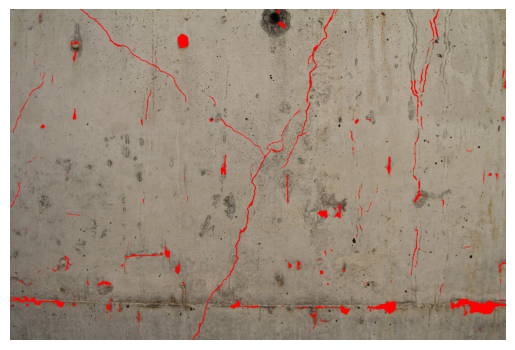

In [57]:
# 出力画像の表示
pred_img = image.copy()
pred_img[pred_mask==1]=[255,0,0]
plt.axis('off')
plt.imshow(pred_img)

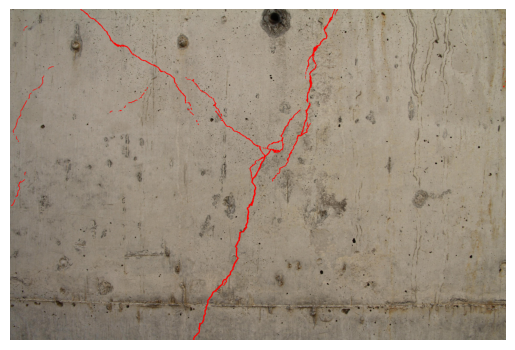

In [52]:
# マスク画像の出力
mask_img = image.copy()
mask_img[mask==1]=[255,0,0]
plt.axis('off')
plt.imshow(mask_img)

In [2]:
# モデルのtest dataでの出力をプロットする
import torch
import torch.utils.data as data
from dataloader.dataset import make_datapath_list, make_datapath_list_supervised, LabeledDataset, ValLabeledTransform
from models.bayesian_deeplab import DeepLabv3plusModel

makepath = make_datapath_list('hoge', first=True)
test_img_list, test_anno_list = makepath.get_list("test")
test_dataset = LabeledDataset(test_img_list, test_anno_list, transform=ValLabeledTransform(crop_size=256))
test_dataloader = data.DataLoader(
    test_dataset, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)

model_wrapper = DeepLabv3plusModel()
model = model_wrapper.get_model()

model = torch.nn.DataParallel(model, device_ids=[0, 1, 2, 3])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [3]:
model2 = model_wrapper.get_model()

model2 = torch.nn.DataParallel(model2, device_ids=[0, 1, 2, 3])
model2 = model2.to(device)

In [4]:
model_path = 'weights/231124/iter1_weights/best.pth'
model.load_state_dict(torch.load(model_path))
model2_path = 'weights/231124/iter4_weights/best.pth'
model2.load_state_dict(torch.load(model2_path))

with torch.no_grad():
    for image,mask in test_dataloader:
        image = image.to(device,dtype=torch.float)
        mask = mask.to(device,dtype=torch.float)

        pred = torch.sigmoid(model.forward(image))
        pred2 = torch.sigmoid(model2.forward(image))
        break

In [24]:
print(image.shape)
print(mask.shape)
print(pred.shape)

torch.Size([16, 3, 256, 256])
torch.Size([16, 1, 256, 256])
torch.Size([16, 1, 256, 256])


In [ ]:
# datasetがrissbilになてる
import torchvision.transforms.functional as F

# 3つの画像を横に並べる
fig, axes = plt.subplots(16, 3, figsize=(12,64))

for i in range(16):
    im = F.to_pil_image(image[i])
    ma = F.to_pil_image(mask[i])
    pr = F.to_pil_image(pred[i])

    # 1番目のサブプロットにオリジナルの画像を表示
    axes[i,0].imshow(im)
    axes[i,0].set_title('Original Image')
    axes[i,0].axis('off')

    # 2番目のサブプロットにマスクを表示
    axes[i,1].imshow(pr, cmap='gray')
    axes[i,1].set_title('Prediction')
    axes[i,1].axis('off')

    # 3番目のサブプロットに予測を表示
    axes[i,2].imshow(ma, cmap='gray')
    axes[i,2].set_title('Label')
    axes[i,2].axis('off')

# 画像を表示
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

In [ ]:
import torchvision.transforms.functional as F

# 3つの画像を横に並べる
fig, axes = plt.subplots(16, 3, figsize=(12,64))

for i in range(16):
    im = F.to_pil_image(image[i])
    ma = F.to_pil_image(mask[i])
    pr = F.to_pil_image(pred2[i])

    # 1番目のサブプロットにオリジナルの画像を表示
    axes[i,0].imshow(im)
    axes[i,0].set_title('Original Image')
    axes[i,0].axis('off')

    # 2番目のサブプロットにマスクを表示
    axes[i,1].imshow(pr, cmap='gray')
    axes[i,1].set_title('Prediction')
    axes[i,1].axis('off')

    # 3番目のサブプロットに予測を表示
    axes[i,2].imshow(ma, cmap='gray')
    axes[i,2].set_title('Label')
    axes[i,2].axis('off')

# 画像を表示
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

In [2]:
# 231217のpred_mean, pred_mean_correctedを二つ並びで表示
pred_mean_path = sorted(glob.glob('data/unlabeled_mask/231217_iter1/pred_mean/*'))
pred_meco_path = sorted(glob.glob('data/unlabeled_mask/231217_iter1/pred_mean_corrected/*'))

In [4]:
# 同じ順序を保ったままランダムにシャッフル
import numpy as np
combined = list(zip(pred_mean_path, pred_meco_path))
np.random.shuffle(combined)

# シャッフルされた配列を元に戻す
pred_mean_path, pred_meco_path = zip(*combined)

In [ ]:
# 画像の表示
fig, axes = plt.subplots(10, 2, figsize=(4,10))

for i in range(10):
    j = i
    pred_mean = plt.imread(pred_mean_path[j])
    pred_meco = plt.imread(pred_meco_path[j])
    if np.array_equal(pred_mean,pred_meco):
        continue

    # Mean
    axes[i, 0].imshow(pred_mean, cmap='gray')
    axes[i, 0].axis('off')
    axes[i, 0].set_title('Before screening')

    # Var
    axes[i, 1].imshow(pred_meco, cmap='gray')
    axes[i, 1].axis('off')
    axes[i, 1].set_title('After screening')

plt.tight_layout()
plt.show()

In [36]:
# ラベルなしデータのpred, varをプロット
image_path = sorted(glob.glob('data/Train/images/Volker*'))
anno_path = sorted(glob.glob('data/Train/masks/Volker*'))
pred_mean1_path = sorted(glob.glob('data/unlabeled_mask/231128_iter1/pred_mean_corrected/*'))
pred_var1_path = sorted(glob.glob('data/unlabeled_mask/231128_iter1/pred_var/*'))

In [37]:
# 同じ順序を保ったままランダムにシャッフル
combined = list(zip(image_path, anno_path, pred_mean1_path, pred_var1_path))
np.random.shuffle(combined)

# シャッフルされた配列を元に戻す
image_path, anno_path, pred_mean1_path, pred_var1_path = zip(*combined)

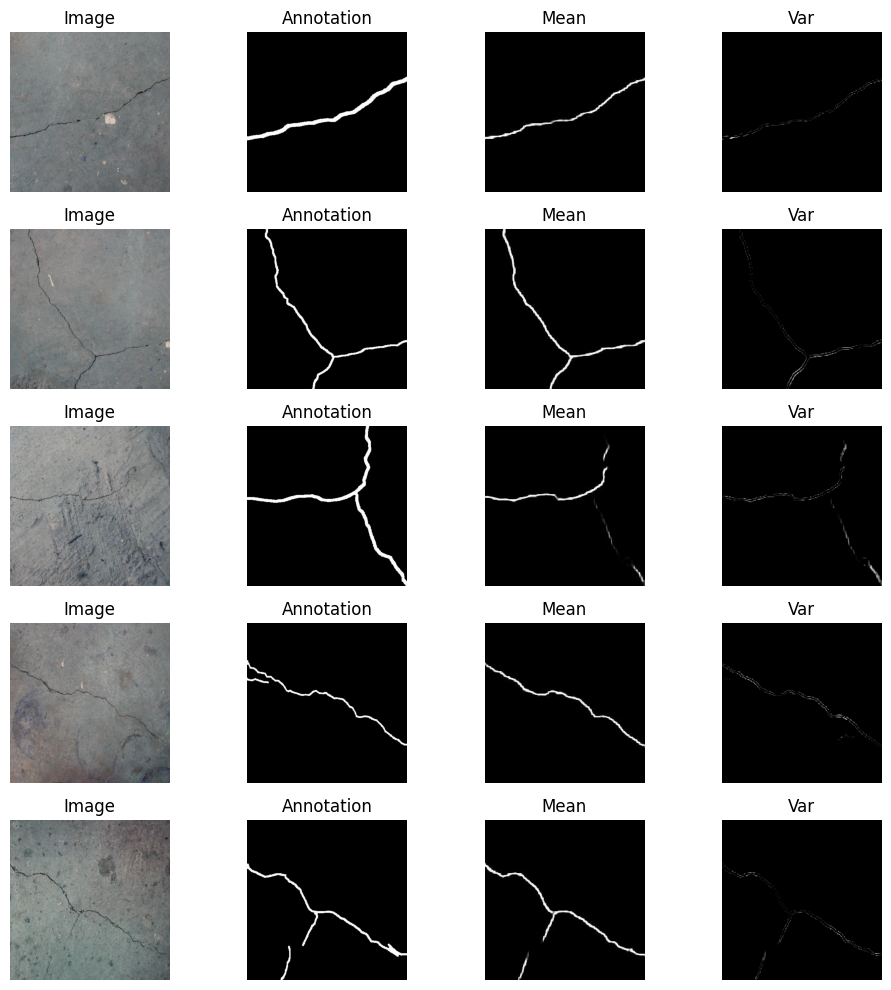

In [45]:
# 画像の表示
fig, axes = plt.subplots(5, 4, figsize=(10,10))

for i in range(5):
    j = i+15
    image = plt.imread(image_path[j])
    anno = plt.imread(anno_path[j])
    pred_mean1 = plt.imread(pred_mean1_path[j])
    pred_var1 = torch.load(pred_var1_path[j])

    # Image
    axes[i, 0].imshow(image)
    axes[i, 0].axis('off')
    axes[i, 0].set_title('Image')

    # Annotation
    axes[i, 1].imshow(anno)
    axes[i, 1].axis('off')
    axes[i, 1].set_title('Annotation')

    # Mean
    axes[i, 2].imshow(pred_mean1, cmap='gray')
    axes[i, 2].axis('off')
    axes[i, 2].set_title('Mean')

    # Var
    axes[i, 3].imshow(pred_var1, cmap='gray')
    axes[i, 3].axis('off')
    axes[i, 3].set_title('Var')

plt.tight_layout()
plt.show()

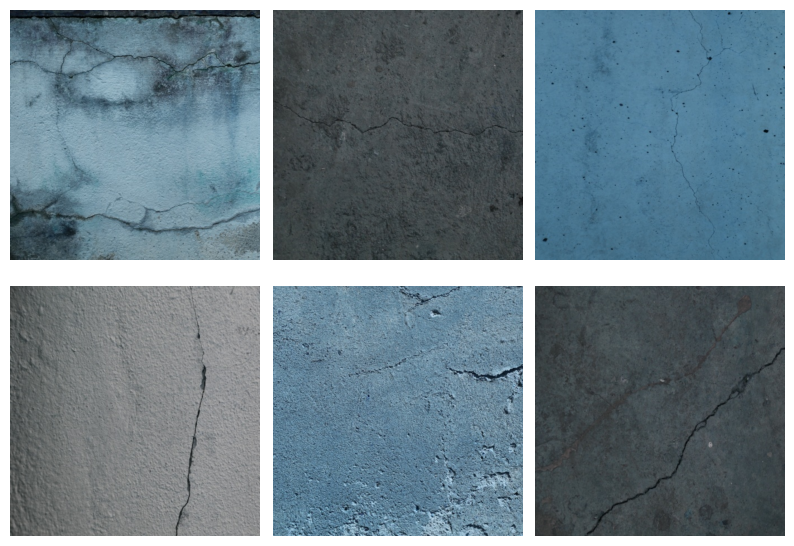

In [10]:
import random
# 各データセットの画像例を(2,3)でプロット
image_path = sorted(glob.glob('data/Train/images/[!Rissbilder]*'))
image_path2 = sorted(glob.glob('data/Train/images/Rissbilder*'))

# ランダムに6つの画像を選択
selected_images = random.sample(image_path2, 6)

# 2行3列に並べて表示
fig, axes = plt.subplots(2, 3, figsize=(10, 7))

for i, image in enumerate(selected_images):
    # 画像を読み込み
    img = Image.open(image)

    # サブプロットに画像を表示
    row = i // 3
    col = i % 3
    axes[row, col].imshow(img)
    axes[row, col].axis('off')
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()

In [24]:
# ソース（変換前）、ソース（変換後）、アノテーションをプロット
sourceb_path = sorted(glob.glob('data/Test/images/[!Rissbilder]*'))
sourcea_path = sorted(glob.glob('data/Test_transform2/images/[!Rissbilder]*'))
anno_path = sorted(glob.glob('data/Test/masks/[!Rissbilder]*'))

In [25]:
# 同じ順序を保ったままランダムにシャッフル
combined = list(zip(sourceb_path, sourcea_path, anno_path))
np.random.shuffle(combined)

# シャッフルされた配列を元に戻す
sourceb_path, sourcea_path, anno_path = zip(*combined)

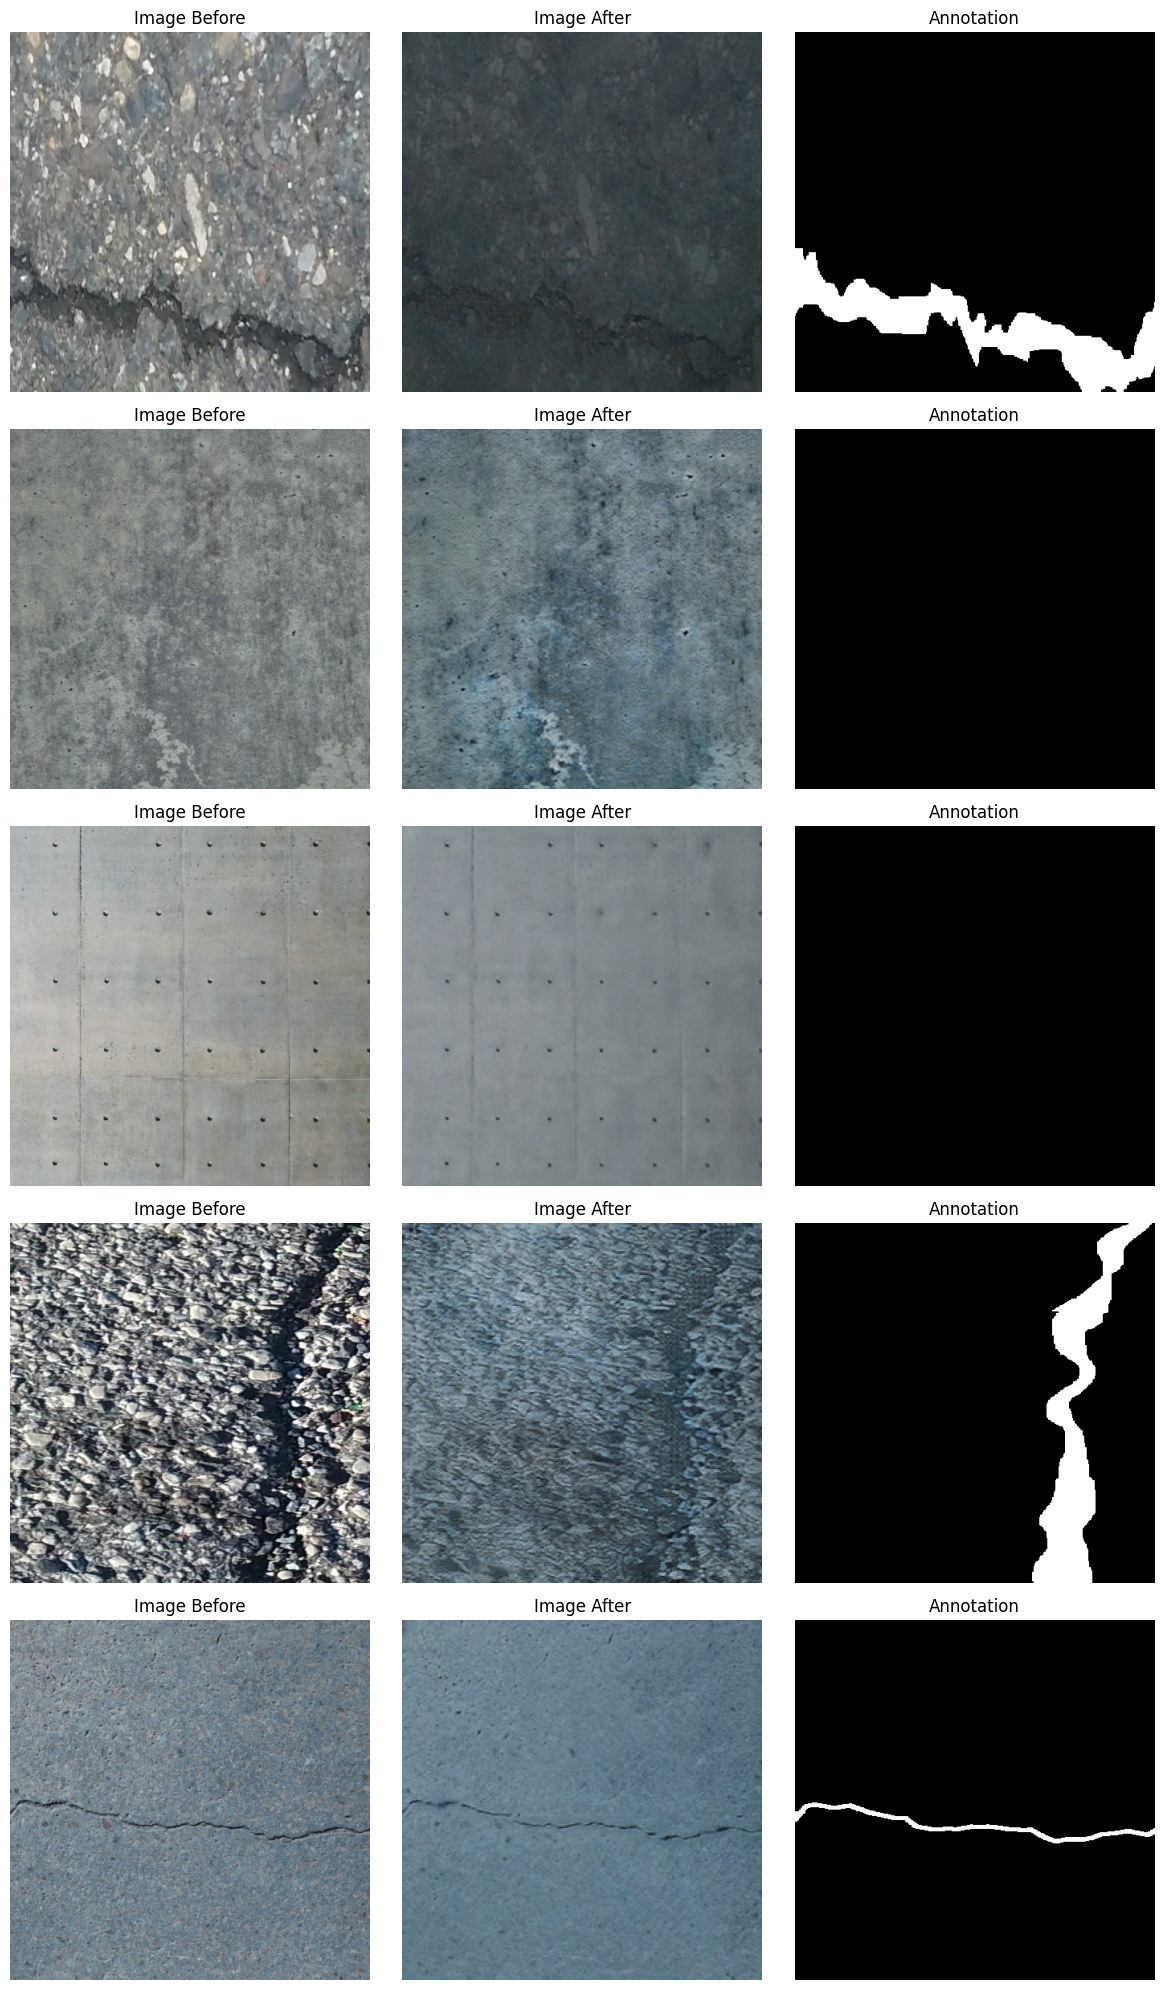

In [29]:
# 画像の表示
fig, axes = plt.subplots(5, 3, figsize=(12, 20))

for i in range(5):
    j = i + 10
    image1 = plt.imread(sourceb_path[j])
    image2 = plt.imread(sourcea_path[j])
    anno = plt.imread(anno_path[j])


    # Image
    axes[i, 0].imshow(image1)
    axes[i, 0].axis('off')
    axes[i, 0].set_title('Image Before')
    
    # Image
    axes[i, 1].imshow(image2)
    axes[i, 1].axis('off')
    axes[i, 1].set_title('Image After')

    # Annotation
    axes[i, 2].imshow(anno, cmap='gray')
    axes[i, 2].axis('off')
    axes[i, 2].set_title('Annotation')


plt.tight_layout()
plt.show()